### Separate OOD data from in-distribution data (education certificates, invoices, immatriculation)

1. load ocr
2. find keywords in ocr
    - immatrikulation
    - rechnung
    - bildungszertifikat
        - bachelor + abschluss
        - bachelor + zeugnis
        - bachelor + urkunde
        - bachelor + zertifikat

        - master + abschluss
        - master + zeugnis
        - master + urkunde
        - master + zertifikat

        - zeugnis + schule
        - zeugnis + realschule
        - zeugnis + gymnasium
        - zeugnis + hauptschule

        - sonstiges
            - zeugnis
            - diplom
            - urkunde
            - zertifikat

In [6]:
from pathlib import Path
from enum import Enum, auto
from tqdm import tqdm

In [4]:
ocr_paths = list(Path("docling").glob("*.md"))

In [ ]:
class CertificateType(Enum):
    IMMATRIKULATION = "immatrikulation"
    RECHNUNG = "rechnung"
    BACHELOR = "bachelor" 
    MASTER = "master"
    SCHULE = "schule"
    DIPLOM = "diplom"
    SONSTIGE_ZERTIFIKATE = "sonstige_zertifikate"

document_type_keywords = {
    CertificateType.IMMATRIKULATION:[
        ("studienbescheinigung", "semester", "name", "matrikelnummer"),
        ("immatrikulation", "semester", "name", "matrikelnummer")
    ],
    CertificateType.RECHNUNG: [
        ("rechnung")
    ],
    CertificateType.BACHELOR: [
        ("bachelor", "abschluss", "matrikelnummer"),
        ("bachelor", "zeugnis", "matrikelnummer"),
        ("bachelor", "urkunde", "matrikelnummer"),
        ("bachelor", "zertifikat", "matrikelnummer"),
    ],
    CertificateType.MASTER: [
        ("master", "abschluss", "matrikelnummer"),
        ("master", "zeugnis", "matrikelnummer"),
        ("master", "urkunde", "matrikelnummer"),
        ("master", "zertifikat", "matrikelnummer"),
    ],
    CertificateType.DIPLOM: [
        ("diplom", "abschluss"),
        ("diplom", "zeugnis"),
        ("diplom", "urkunde"),
        ("diplom", "zertifikat"),
    ],
    CertificateType.SCHULE: [
        ("zeugnis", "schule"),
        ("zeugnis", "realschule"),
        ("zeugnis", "gymnasium"),
        ("zeugnis", "hauptschule"),
    ],
    CertificateType.SONSTIGE_ZERTIFIKATE: [
        ("zeugnis"),
        ("urkunde"),
        ("zertifikat"),
    ],
}

classification_results = {certificate_type.name: [] for certificate_type in CertificateType}

for path in tqdm(ocr_paths[:5000]):
    text = path.open("r").read()

    text = text.lower()

    for certificate_type, keywords in document_type_keywords.items():
        for keyword_tuple in keywords:
            if isinstance(keyword_tuple, tuple):
                if all(word.lower() in text.lower() for word in keyword_tuple):
                    classification_results[certificate_type.name].append(path)
                    break
            else:
                if keyword_tuple.lower() in text.lower():
                    classification_results[certificate_type.name].append(path)
                    break


In [ ]:
len(classification_results[CertificateType.IMMATRIKULATION.name])

In [ ]:
%pip install pymupdf

In [52]:
import pymupdf
import io
from PIL import Image


In [ ]:
doc_path = classification_results[CertificateType.BACHELOR.name][0]
pdf_path =Path("pdfs", doc_path.stem + ".pdf")

pdf = pymupdf.open(pdf_path)

pixmap = list(pdf.pages())[0].get_pixmap().tobytes()

Image.open(io.BytesIO(pixmap))

In [1]:
%pip install ollama

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 227.4 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.6/442.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.14
    Uninstalling pydantic-1.10.14:
      Successfully uninstalled pydantic-1.10.14
ERROR: pip's dependency resolver does not currently take into account all the p

In [2]:
%pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 61.9 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import ollama
from pydantic import BaseModel
from pathlib import Path
import pymupdf
from PIL import Image
import io
import base64
import json
from tqdm import tqdm
from pydantic import BaseModel, Field


In [4]:
class DokumentInfo(BaseModel):
    ist_bildungs_abschluss_zeugnis: bool = Field(
        description="Gibt an, ob das Dokument ein Abschlusszeugnis im Bildungsbereich ist (z. B. Bachelor, Master, Diplom, Ausbildung, Weiterbildung)."
    )
    ist_rechnung: bool = Field(
        description="Gibt an, ob das Dokument eine Rechnung ist."
    )
    ist_immatrikulationsbescheinigung: bool = Field(
        description="Gibt an, ob das Dokument eine Immatrikulationsbescheinigung ist."
    )

In [5]:
class DocumentClassification():
    def __init__(self, storage_path: Path = Path("classification_results.json")):
        self.storage_path = storage_path
        if storage_path.exists():
            self.classification_results = json.load(storage_path.open("r"))
        else:
            self.classification_results = {}

    @staticmethod
    def display_document(document_id):
        pdf_path =Path("pdfs", document_id + ".pdf")
        pdf = pymupdf.open(pdf_path)
        pixmap = list(pdf.pages())[0].get_pixmap().tobytes()
        return Image.open(io.BytesIO(pixmap))
    
    @staticmethod
    def classify_document(document_id):
        pdf_path = Path("pdfs", document_id + ".pdf")

        #ocr_path = Path("docling", document_id + ".md")

        #ocr_text = ocr_path.open("r").read()

        pdf = pymupdf.open(pdf_path)

        page = list(pdf.pages())[0]
        image_bytes = page.get_pixmap().tobytes()
        image_base64 = base64.b64encode(image_bytes).decode('utf-8')

        summary = ollama.chat(
            model='gemma3:27b',
            messages=[{
                'role': 'user',
                'content': f"""Beschreibe kurz die Form des folgenden Dokuments, indem du seinen Typ kategorisierst. Antworte mit einem Satz - so kurz wie möglich.""",
                'images': [image_base64]
            }]
        )

        summary = summary.message.content

        classification = ollama.chat(
            model='qwq',
            messages=[{
                'role': 'user',
                'content': f"""Beantworte anhand der folgenden Zusammenfassung: Ist das Dokument ein Zeugnis/Zertifikat für einen Bildungsabschluss (Bachelor, Master, Diplom, Ausbildung, Weiterbildung, ...), eine Rechnung, eine Immatrikulationsbescheinigung oder ein sonstiges Dokument?
                            {summary}""",
            }]
        )
        classification = classification.message.content

        classification = classification.split("</think>")[1]

        structured_response = ollama.chat(
            model='qwq',
            messages=[{
                'role': 'user',
                'content': f"""Basierend auf der folgenden Zusammenfassung, ordne das Dokument den folgenden Kategorien zu:                         
                            Kategorisierung:
                            ----------------
                            {classification}"""
            }],
            format=DokumentInfo.model_json_schema()
        )

        structured_response = structured_response.message.content
        return json.loads(structured_response), summary
    

    def classify_documents(self, metadata_path: Path = Path("metadata"), language: str = "de"):
        document_paths = list(metadata_path.glob("*.json"))
        for document_path in tqdm(document_paths):
            metadata = json.load(document_path.open("r"))
            is_german = metadata["language_metadata"]["language"] == language
            if not is_german:
                continue
            document_id = document_path.stem
            if document_id in self.classification_results:
                continue
            result, summary = DocumentClassification.classify_document(document_id)
            self.classification_results[document_id] = {**result, "zusammenfassung": summary}
            json.dump(self.classification_results, self.storage_path.open("w"), indent=4, ensure_ascii=False)

In [6]:
document_classification = DocumentClassification()

In [7]:
document_classification.classify_documents()

  1%|          | 484/50718 [24:17<246:32:26, 17.67s/it]

: 

In [86]:
list(classification_results.keys())[1]

'ist_master_zertifikat'

In [1]:
from pathlib import Path
import json

In [2]:
classification_results = json.load(Path("classification_results.json").open("r"))

In [3]:
list(classification_results.keys())[0]

'20080'

In [9]:
rechnungen = []
abschluss_zeugnisse = []
for key, value in document_classification.classification_results.items():
    if value["ist_rechnung"]:
        rechnungen.append(key)
    if value["ist_bildungs_abschluss"]:
        abschluss_zeugnisse.append(key)

In [6]:
rechnungen

['20219',
 '4141',
 '21433',
 '27318',
 '41438',
 '6299',
 '17852',
 '19315',
 '9816',
 '3240']

In [10]:
abschluss_zeugnisse

['47582',
 '41598',
 '40702',
 '20304',
 '14228',
 '4716',
 '47713',
 '12349',
 '45766',
 '47001',
 '33527',
 '42737',
 '42951',
 '46647',
 '15704']

In [22]:
document_classification.classification_results[abschluss_zeugnisse[10]]

{'dokument_typ': 'Anlageverzeichnis',
 'ist_bildungs_abschluss': True,
 'ist_rechnung': False,
 'ist_immatrikulationsbescheinigung': False,
 'zusammenfassung': 'Das Dokument ist ein Anlageverzeichnis, das die Vermögenswerte eines Unternehmens am 31.12.2010 detailliert auflistet.'}

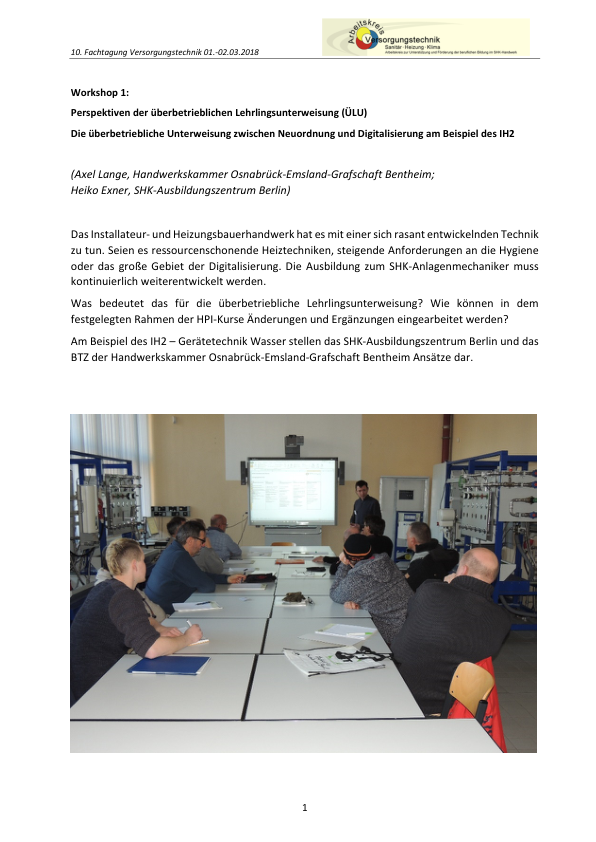

In [39]:
document_classification.display_document(abschluss_zeugnisse[12])

In [40]:
document_classification.classify_document(abschluss_zeugnisse[12])



Das Dokument ist **kein Abschlusszeugnis, keine Rechnung oder eine Immatrikulationsbescheinigung**, sondern fällt in die Kategorie **"sonstiges Dokument"**. Die genannten Merkmale – Überschriften, Text und ein Bild – sind typisch für **Präsentationen oder Workshop-Protokolle**, die eine strukturierte Darstellung von Inhaltsabschnitten, Erläuterungen und visuellen Elementen aufweisen. 

### Begründung:
- **Abschlusszeugnisse** (Bachelor/Master/Diplom/Ausbildung) enthalten hingegen formelle Angaben über den Abschluss (z. B. Titel, Noten, Signatur, Siegel) und sind nicht visuell aufbereitet.
- **Rechnungen** enthalten finanzielle Details (Preise, Leistungen, Zahlungsbedingungen) und keine thematischen Überschriften oder Bilder.
- **Immatrikulationsbescheinigungen** sind formelle Bestätigungen zur Teilnahme an einem Studium/Studiengang und folgen einem festen, nicht präsentationsähnlichen Layout.

Da die beschriebenen Elemente typisch für informelle, strukturierte Dokumente wie Präsentat

({'ist_bildungs_abschluss': False,
  'ist_rechnung': False,
  'ist_immatrikulationsbescheinigung': False},
 'Das Dokument ist eine Präsentation oder ein Workshop-Protokoll, da es Überschriften, Text und ein Bild enthält, die typisch für solche Formate sind.')